In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import sys
import tensorflow as tf
from tensorflow.keras import layers, Model

sys.path.append('..')
from src.data.make_dataset import make_dataset

In [12]:
DATA_PATH = '../data/processed/EEA-SK-Ba-trend.csv'
N_PAST = 48
N_FUTURE = 1

In [13]:
df = pd.read_csv(DATA_PATH)
# take only data until 2019 based on DatetimeBegin column
df['DatetimeBegin'] = pd.to_datetime(df['DatetimeBegin'])
df = df[df['DatetimeBegin'] < '2020-01-01']
df = df[['PM10 Concentration', 'PM2.5 Concentration', 'NO2 Concentration']]

In [14]:
train_X, train_Y, val_X, val_Y, test_X = make_dataset(data_src=df, n_past=N_PAST, n_future=N_FUTURE)

In [15]:
in_scaler = StandardScaler()
out_scaler = StandardScaler()

train_X = train_X.reshape(-1, train_X.shape[-1])
train_X = in_scaler.fit_transform(train_X)
train_X = train_X.reshape(-1, N_PAST, train_X.shape[-1])

train_Y = train_Y.reshape(-1, train_Y.shape[-1])
train_Y = out_scaler.fit_transform(train_Y)
train_Y = train_Y.reshape(-1, N_FUTURE, train_Y.shape[-1])

val_X = val_X.reshape(-1, val_X.shape[-1])
val_X = in_scaler.transform(val_X)
val_X = val_X.reshape(-1, N_PAST, val_X.shape[-1])

val_Y = val_Y.reshape(-1, val_Y.shape[-1])
val_Y = out_scaler.transform(val_Y)
val_Y = val_Y.reshape(-1, N_FUTURE, val_Y.shape[-1])

real_values = test_X.copy()[:, -1, :]
test_X = test_X.reshape(-1, test_X.shape[-1])
test_X = in_scaler.transform(test_X)
test_X = test_X.reshape(-1, N_PAST, test_X.shape[-1])

In [16]:
print(f'Train set shape: {train_X.shape}         Train labels shape: {train_Y.shape}')
print(f'Validation set shape: {val_X.shape}     Validation labels shape: {val_Y.shape}')
print(f'Test set shape: {test_X.shape}')

Train set shape: (12214, 48, 3)         Train labels shape: (12214, 1, 3)
Validation set shape: (2580, 48, 3)     Validation labels shape: (2580, 1, 3)
Test set shape: (2580, 48, 3)


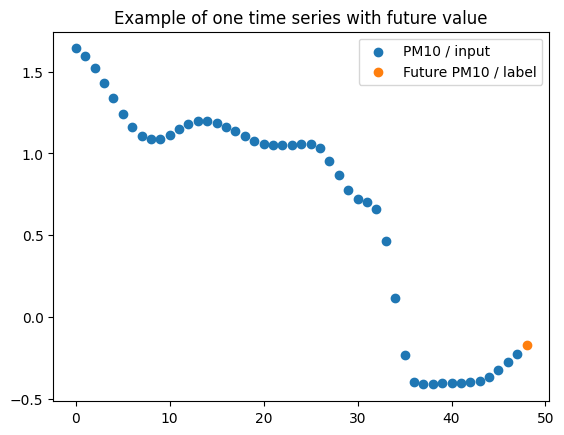

In [17]:
x = np.random.randint(0, train_X.shape[0] - N_PAST - 1)
plt.scatter(range(N_PAST), train_X[x, :, 1], label='PM10 / input')
tmp = np.empty((N_PAST, 1))
tmp[:] = np.nan
tmp = np.append(tmp, np.array(train_Y[x, 0, 1]))
plt.scatter(range(N_PAST + 1), tmp, label='Future PM10 / label')
plt.title('Example of one time series with future value')
plt.legend()
plt.show()

### Modelling

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

In [19]:
def lstm_model(lr=0.001):
    model = tf.keras.Sequential([
        layers.LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True),
        layers.LSTM(16, return_sequences=False),
        # layers.Dropout(0.2),
        # layers.Dense(8, activation='relu'),
        layers.Dense(3)
    ], name='LSTM')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )

    return model

lstm1 = lstm_model()
lstm1.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 48, 32)            4608      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 7795 (30.45 KB)
Trainable params: 7795 (30.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


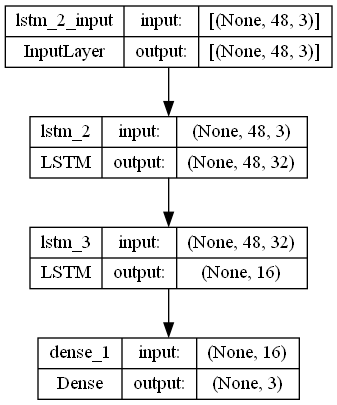

In [20]:
tf.keras.utils.plot_model(lstm1, to_file='lstm.png', show_shapes=True)

In [21]:
def lstm_model_v2(lr=0.001):
    model = tf.keras.Sequential([
        layers.LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True),
        layers.LSTM(16, return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dense(3)
    ], name='LSTM-v2')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )

    return model

lstm2 = lstm_model_v2()
lstm2.summary()

Model: "LSTM-v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 48, 32)            4608      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 7907 (30.89 KB)
Trainable params: 7907 (30.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


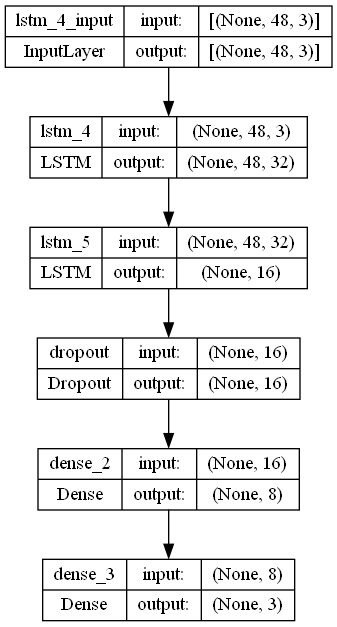

In [22]:
tf.keras.utils.plot_model(lstm2, to_file='lstm2.png', show_shapes=True)

In [23]:
def lstm_cnn_model(lr=0.001):
    model = tf.keras.Sequential([
        layers.Conv1D(32, activation='relu', kernel_size=3, input_shape=(train_X.shape[1], train_X.shape[2])),
        layers.MaxPooling1D(),
        layers.Conv1D(32, activation='relu', kernel_size=3),
        layers.MaxPooling1D(2),
        layers.LSTM(32, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True),
        layers.LSTM(16, activation='relu', return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dense(3)
    ], name='LSTM_CNN')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )

    return model

lstm_cnn = lstm_cnn_model()
lstm_cnn.summary()


Model: "LSTM_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 32)            320       
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_7 (LSTM)               (None, 16)                31

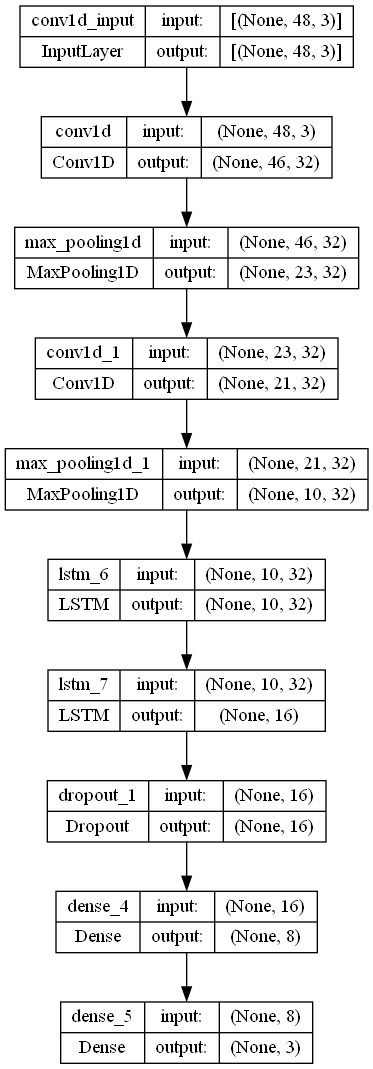

In [24]:
tf.keras.utils.plot_model(lstm_cnn, to_file='lstm_cnn.png', show_shapes=True)

In [25]:
def lstm_cnn_skip_model(lr=0.001):
    inputs = layers.Input(shape=(train_X.shape[1], train_X.shape[2]))
    conv1 = layers.Conv1D(32, activation='relu', kernel_size=3)(inputs)
    pool1 = layers.MaxPooling1D(2)(conv1)
    conv2 = layers.Conv1D(32, activation='relu', kernel_size=3)(pool1)
    pool2 = layers.MaxPooling1D(2)(conv2)
    lstm1 = layers.LSTM(32, activation='relu', return_sequences=True)(pool2)
    lstm2 = layers.LSTM(16, activation='relu', return_sequences=False)(lstm1)

    lstm3 = layers.LSTM(16, activation='relu', return_sequences=False)(inputs)
    
    concat = layers.Concatenate()([lstm2, lstm3])
    drop1 = layers.Dropout(0.2)(concat)
    dense1 = layers.Dense(8, activation='relu')(drop1)
    outputs = layers.Dense(3)(dense1)

    model = Model(inputs=inputs, outputs=outputs, name='LSTM_CNN_SKIP')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )

    return model

lstm_cnn_skip = lstm_cnn_skip_model()
lstm_cnn_skip.summary()

Model: "LSTM_CNN_SKIP"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 3)]              0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 46, 32)               320       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 23, 32)               0         ['conv1d_2[0][0]']            
 g1D)                                                                                             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 21, 32)               3104      ['max_pooling1d_2[

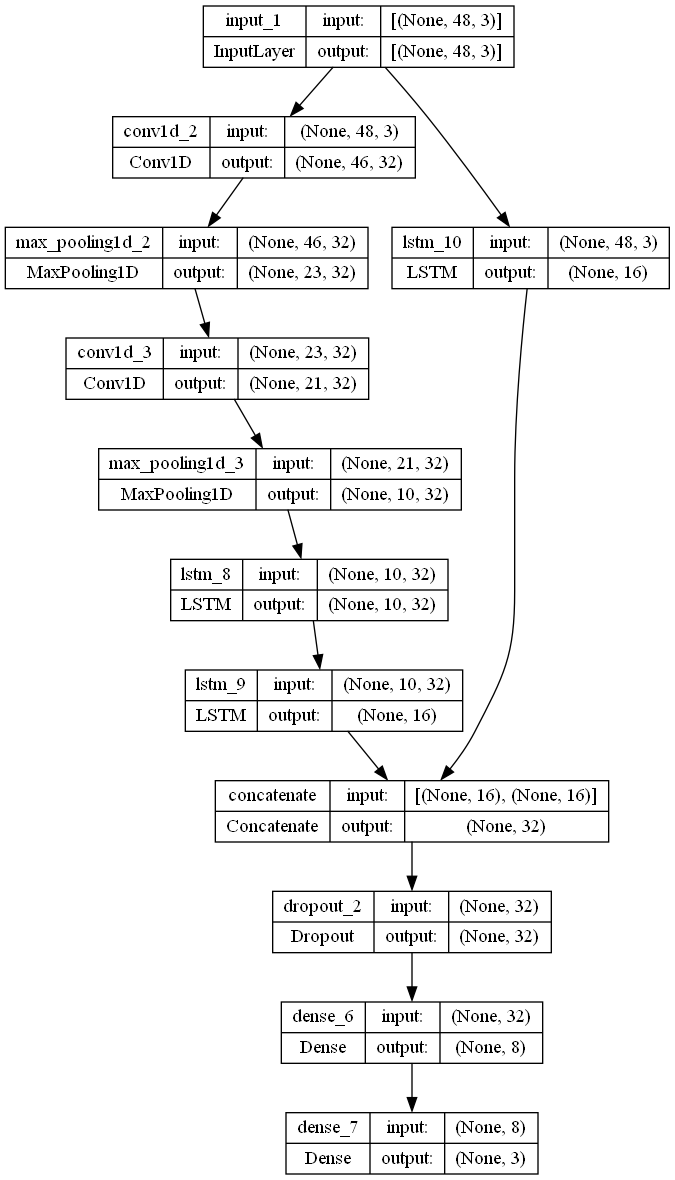

In [26]:
tf.keras.utils.plot_model(lstm_cnn_skip, to_file='lstm_cnn_skip.png', show_shapes=True)

### Model training

In [27]:
def makeSubplots(modelName, trainHistory, predictions):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0, 0].plot(trainHistory.history['loss'], label='train loss')
    axes[0, 0].plot(trainHistory.history['val_loss'], label='val loss')
    axes[0, 0].set_title(f'{modelName} training loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(real_values[:, 0], label='Real values (trend)')
    axes[0, 1].plot(predictions[:, 0], label=f'{modelName} predictions')
    axes[0, 1].set_title(f'{modelName} PM10 predictions')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('PM10 concentration')
    axes[0, 1].legend()

    axes[1, 0].plot(real_values[:, 1], label='Real values (trend)')
    axes[1, 0].plot(predictions[:, 1], label=f'{modelName} predictions')
    axes[1, 0].set_title(f'{modelName} PM2.5 predictions')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('PM2.5 concentration')
    axes[1, 0].legend()

    axes[1, 1].plot(real_values[:, 2], label='Real values (trend)')
    axes[1, 1].plot(predictions[:, 2], label=f'{modelName} predictions')
    axes[1, 1].set_title(f'{modelName} NO2 predictions')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('NO2 concentration')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [28]:
model1_hist = lstm1.fit(
    train_X, train_Y,
    validation_data=(val_X, val_Y),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],
    shuffle=False
)

Epoch 1/50

764/764 [==============================] - 20s 20ms/step - loss: 0.2995 - mean_absolute_error: 0.3954 - mean_absolute_percentage_error: 237.7044 - val_loss: 0.1201 - val_mean_absolute_error: 0.2447 - val_mean_absolute_percentage_error: 174.0801
Epoch 2/50
764/764 [==============================] - 13s 18ms/step - loss: 0.2348 - mean_absolute_error: 0.3332 - mean_absolute_percentage_error: 216.6296 - val_loss: 0.1118 - val_mean_absolute_error: 0.2303 - val_mean_absolute_percentage_error: 155.8997
Epoch 3/50
764/764 [==============================] - 13s 17ms/step - loss: 0.2227 - mean_absolute_error: 0.3209 - mean_absolute_percentage_error: 207.7023 - val_loss: 0.1082 - val_mean_absolute_error: 0.2244 - val_mean_absolute_percentage_error: 151.3345
Epoch 4/50
764/764 [==============================] - 13s 17ms/step - loss: 0.2164 - mean_absolute_error: 0.3147 - mean_absolute_percentage_error: 202.6010 - val_loss: 0.1059 - val_mean_absolute_error: 0.2211 - val_mean_absolute_pe

81/81 [==============================] - 1s 6ms/step


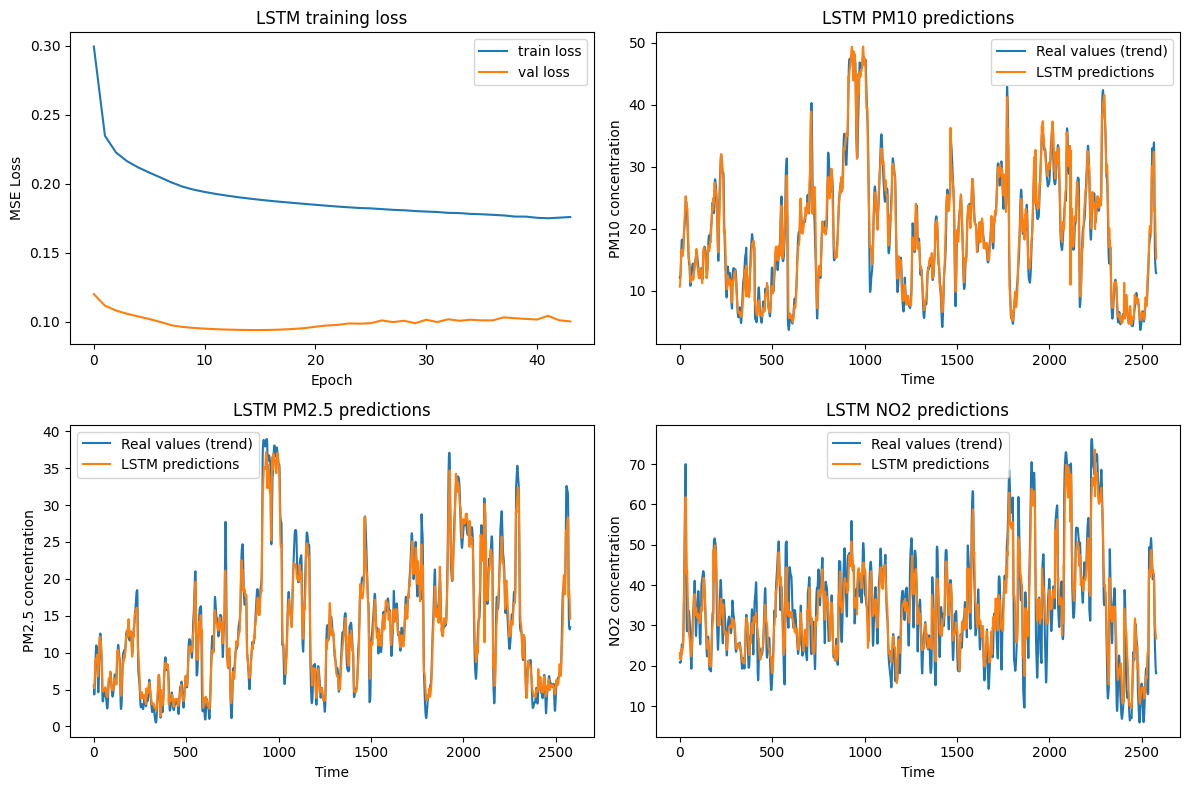

In [29]:
lstm_preds = lstm1.predict(test_X)
lstm_preds = out_scaler.inverse_transform(lstm_preds)
makeSubplots(lstm1.name, model1_hist, lstm_preds)

In [30]:
model2_hist = lstm2.fit(
    train_X, train_Y,
    validation_data=(val_X, val_Y),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],
    shuffle=False
)

Epoch 1/50
764/764 [==============================] - 19s 20ms/step - loss: 0.4545 - mean_absolute_error: 0.5166 - mean_absolute_percentage_error: 277.3216 - val_loss: 0.1235 - val_mean_absolute_error: 0.2535 - val_mean_absolute_percentage_error: 198.2578
Epoch 2/50
764/764 [==============================] - 13s 17ms/step - loss: 0.2854 - mean_absolute_error: 0.3880 - mean_absolute_percentage_error: 252.7124 - val_loss: 0.1156 - val_mean_absolute_error: 0.2405 - val_mean_absolute_percentage_error: 179.1829
Epoch 3/50
764/764 [==============================] - 14s 19ms/step - loss: 0.2587 - mean_absolute_error: 0.3638 - mean_absolute_percentage_error: 232.5007 - val_loss: 0.1128 - val_mean_absolute_error: 0.2358 - val_mean_absolute_percentage_error: 164.3006
Epoch 4/50
764/764 [==============================] - 14s 18ms/step - loss: 0.2479 - mean_absolute_error: 0.3531 - mean_absolute_percentage_error: 226.2789 - val_loss: 0.1117 - val_mean_absolute_error: 0.2349 - val_mean_absolute_per

81/81 [==============================] - 1s 6ms/step


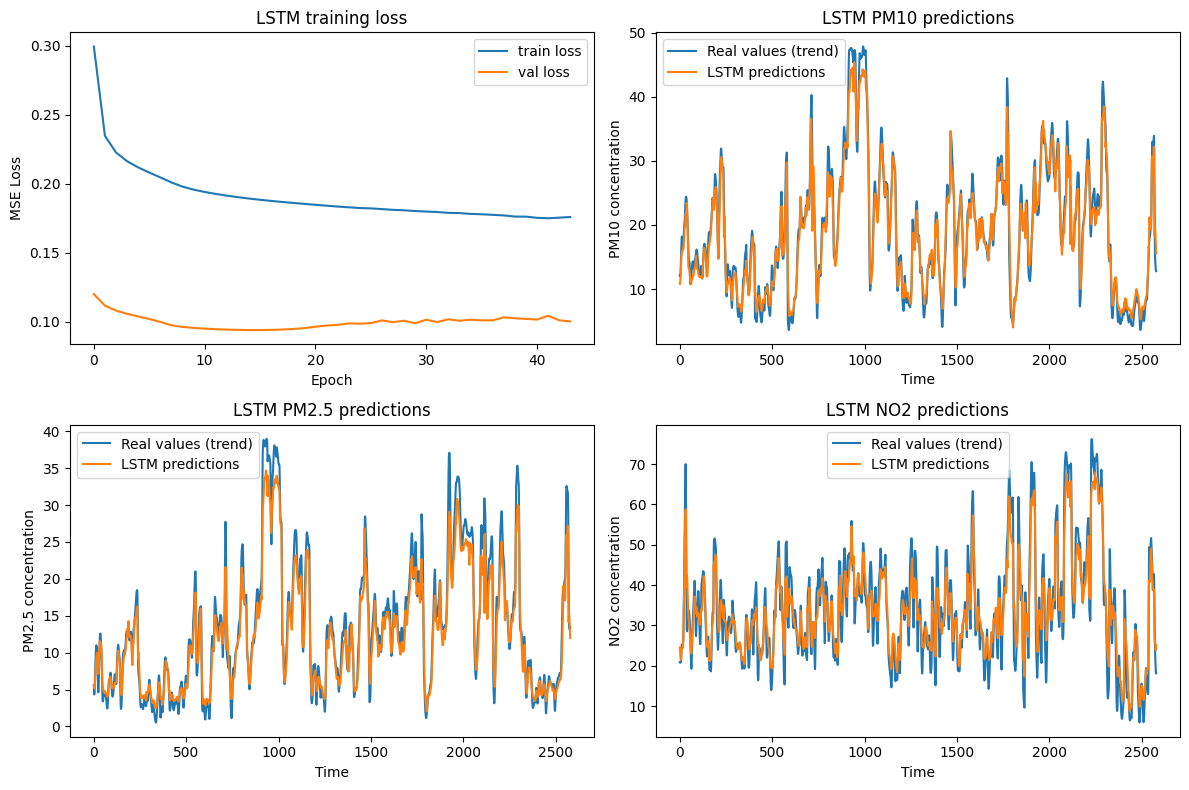

In [31]:
lstm2_preds = lstm2.predict(test_X)
lstm2_preds = out_scaler.inverse_transform(lstm2_preds)
makeSubplots(lstm1.name, model1_hist, lstm2_preds)

In [32]:
model3_hist = lstm_cnn.fit(
    train_X, train_Y,
    validation_data=(val_X, val_Y),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],
    shuffle=False
)

Epoch 1/50
764/764 [==============================] - 9s 8ms/step - loss: 0.7741 - mean_absolute_error: 0.6985 - mean_absolute_percentage_error: 205.0743 - val_loss: 0.2376 - val_mean_absolute_error: 0.3662 - val_mean_absolute_percentage_error: 266.1819
Epoch 2/50
764/764 [==============================] - 5s 7ms/step - loss: 0.4949 - mean_absolute_error: 0.5385 - mean_absolute_percentage_error: 323.5441 - val_loss: 0.1938 - val_mean_absolute_error: 0.3354 - val_mean_absolute_percentage_error: 287.1495
Epoch 3/50
764/764 [==============================] - 5s 6ms/step - loss: 0.4064 - mean_absolute_error: 0.4822 - mean_absolute_percentage_error: 310.5633 - val_loss: 0.1813 - val_mean_absolute_error: 0.3241 - val_mean_absolute_percentage_error: 264.4184
Epoch 4/50
764/764 [==============================] - 6s 8ms/step - loss: 0.3805 - mean_absolute_error: 0.4632 - mean_absolute_percentage_error: 296.6485 - val_loss: 0.1715 - val_mean_absolute_error: 0.3143 - val_mean_absolute_percentage_

81/81 [==============================] - 1s 4ms/step


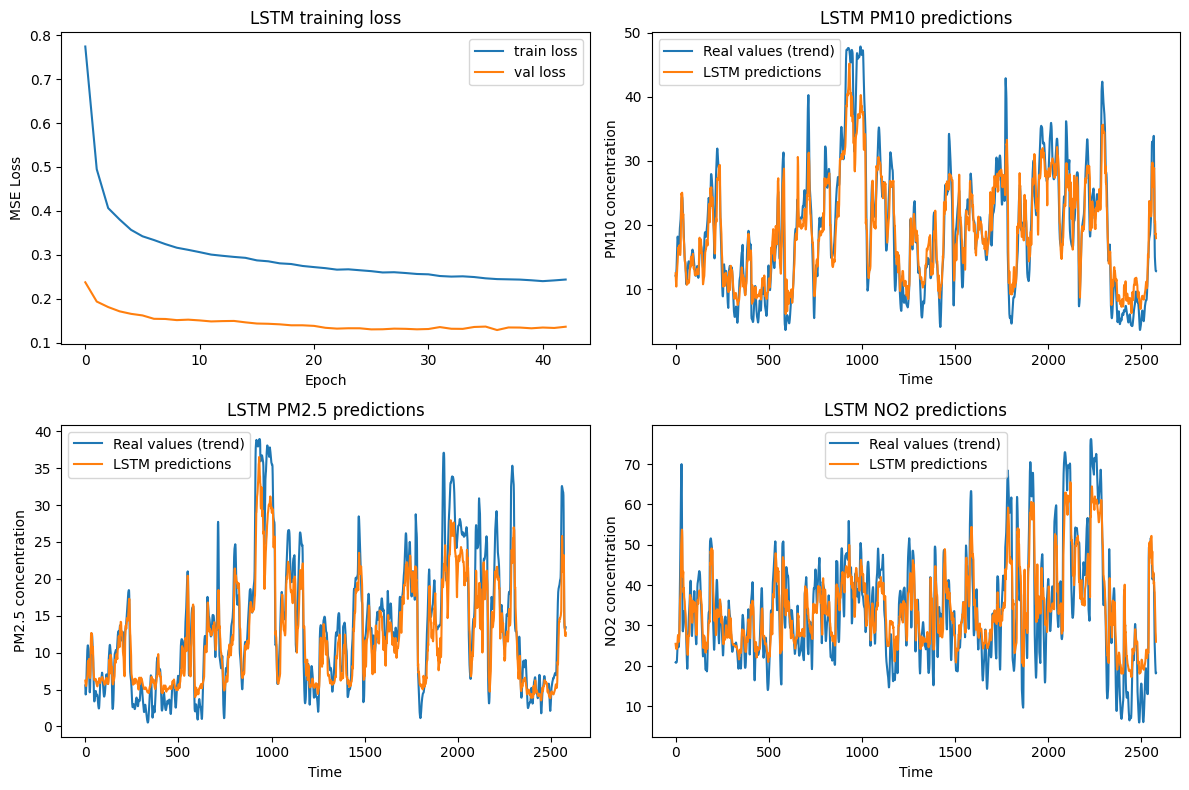

In [33]:
lstm_cnn_preds = lstm_cnn.predict(test_X)
lstm_cnn_preds = out_scaler.inverse_transform(lstm_cnn_preds)
makeSubplots(lstm1.name, model3_hist, lstm_cnn_preds)

In [34]:
model4_hist = lstm_cnn_skip.fit(
    train_X, train_Y,
    validation_data=(val_X, val_Y),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],
    shuffle=False
)

Epoch 1/50
764/764 [==============================] - 16s 12ms/step - loss: 0.4329 - mean_absolute_error: 0.5001 - mean_absolute_percentage_error: 232.9458 - val_loss: 0.1402 - val_mean_absolute_error: 0.2821 - val_mean_absolute_percentage_error: 237.9089
Epoch 2/50
764/764 [==============================] - 9s 12ms/step - loss: 0.2963 - mean_absolute_error: 0.3986 - mean_absolute_percentage_error: 239.4268 - val_loss: 0.1240 - val_mean_absolute_error: 0.2593 - val_mean_absolute_percentage_error: 217.3072
Epoch 3/50
764/764 [==============================] - 8s 11ms/step - loss: 0.2716 - mean_absolute_error: 0.3781 - mean_absolute_percentage_error: 229.4234 - val_loss: 0.1157 - val_mean_absolute_error: 0.2453 - val_mean_absolute_percentage_error: 199.6126
Epoch 4/50
764/764 [==============================] - 9s 11ms/step - loss: 0.2647 - mean_absolute_error: 0.3710 - mean_absolute_percentage_error: 229.5790 - val_loss: 0.1141 - val_mean_absolute_error: 0.2434 - val_mean_absolute_percen

81/81 [==============================] - 1s 4ms/step


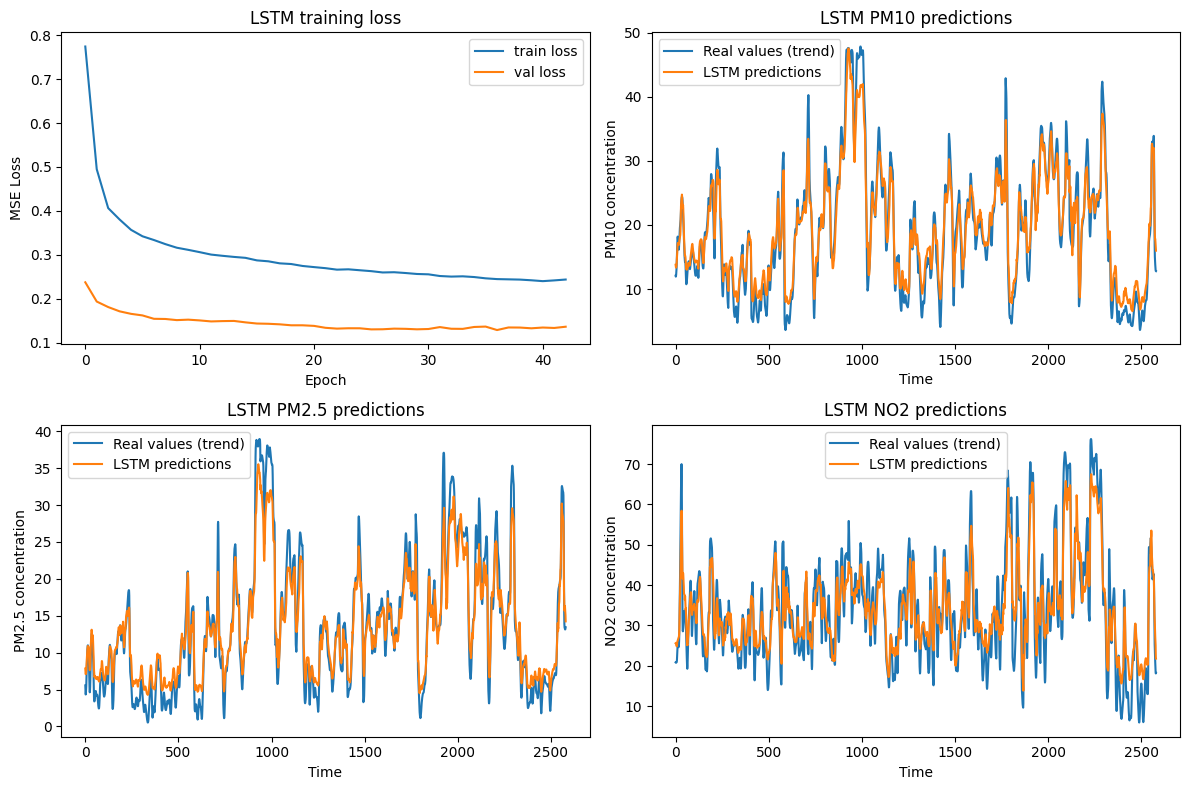

In [35]:
lstm_cnn_skip_preds = lstm_cnn_skip.predict(test_X)
lstm_cnn_skip_preds = out_scaler.inverse_transform(lstm_cnn_skip_preds)
makeSubplots(lstm1.name, model3_hist, lstm_cnn_skip_preds)

### Evaluation

In [36]:
def calculateMetrics(predictions):
    mae = mean_absolute_error(real_values[:, 0], predictions[:, 0])
    mape = mean_absolute_percentage_error(real_values[:, 1], predictions[:, 1])
    rmse = np.sqrt(mean_squared_error(real_values[:, 2], predictions[:, 2]))
    return [mae, mape, rmse]

lstm1_metrics = calculateMetrics(lstm_preds)
lstm2_metrics = calculateMetrics(lstm2_preds)
lstm_cnn_metrics = calculateMetrics(lstm_cnn_preds)
lstm_cnn_skip_metrics = calculateMetrics(lstm_cnn_skip_preds)

# combine all metrics into one dataframe
metrics = pd.DataFrame({
    'LSTM': lstm1_metrics,
    'LSTM-v2': lstm2_metrics,
    'LSTM-CNN': lstm_cnn_metrics,
    'LSTM-CNN-SKIP': lstm_cnn_skip_metrics
}, index=['MAE', 'MAPE', 'RMSE'])

metrics.transpose()

,MAE,MAPE,RMSE
LSTM,1.287546,0.155752,4.765866
LSTM-v2,1.431499,0.168695,4.422874
LSTM-CNN,2.672926,0.326303,6.495688
LSTM-CNN-SKIP,1.901967,0.292161,5.342538


In [37]:
# Save tho models to ../models/
lstm1.save('../models/lstm1.keras')
lstm2.save('../models/lstm2.keras')
lstm_cnn.save('../models/lstm_cnn.keras')
lstm_cnn_skip.save('../models/lstm_cnn_skip.keras')